# Global Power Plant Database — NumPy, Pandas & Matplotlib Integration

**Objective:** Analyze the Global Power Plant Database (World Resources Institute) using NumPy for statistical and matrix operations, Pandas for data manipulation, and Matplotlib/Seaborn for visualization.

**Dataset:** ~35,000 power plants worldwide with capacity, fuel type, location, commissioning year, and generation data.

## 0. Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats

# plot style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "figure.dpi": 100
})

import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded successfully.")

Libraries loaded successfully.


---
## 1. Data Import and Cleaning

We load the CSV with Pandas, inspect its shape and dtypes, then handle missing values and type conversions using NumPy where relevant.

In [2]:
#load data
df = pd.read_csv("/Users/Ethan/DI172/Week8/Day4/DailyChallenge/global_power_plant_database.csv", low_memory=False)
print(f"Dataset shape: {df.shape}")
df.head(3)

Dataset shape: (34936, 36)


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.119,Hydro,NaN,NaN,...,123.77,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.795,Solar,NaN,NaN,...,18.43,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.792,Solar,NaN,NaN,...,18.64,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE


In [3]:
#quick overview of columns and types
df.info(verbose=True, show_counts=True)

<class 'pandas.DataFrame'>
RangeIndex: 34936 entries, 0 to 34935
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         34936 non-null  str    
 1   country_long                    34936 non-null  str    
 2   name                            34936 non-null  str    
 3   gppd_idnr                       34936 non-null  str    
 4   capacity_mw                     34936 non-null  float64
 5   latitude                        34936 non-null  float64
 6   longitude                       34936 non-null  float64
 7   primary_fuel                    34936 non-null  str    
 8   other_fuel1                     1944 non-null   str    
 9   other_fuel2                     276 non-null    str    
 10  other_fuel3                     92 non-null     str    
 11  commissioning_year              17447 non-null  float64
 12  owner                           20868 non-n

### 1.1 Missing Values Analysis

In [4]:
#count and percentage of missing values per column
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
missing_df = missing_df[missing_df.missing_count > 0].sort_values("missing_pct", ascending=False)
print(missing_df.to_string())

                               missing_count  missing_pct
other_fuel3                            34844        99.74
other_fuel2                            34660        99.21
other_fuel1                            32992        94.44
generation_gwh_2013                    28519        81.63
generation_gwh_2014                    27710        79.32
generation_gwh_2015                    26733        76.52
generation_gwh_2016                    25792        73.83
generation_gwh_2017                    25436        72.81
generation_gwh_2018                    25299        72.42
generation_gwh_2019                    25277        72.35
generation_data_source                 23536        67.37
year_of_capacity_data                  20049        57.39
estimated_generation_gwh_2013          18816        53.86
wepp_id                                18702        53.53
estimated_generation_gwh_2014          18433        52.76
estimated_generation_gwh_2015          17886        51.20
commissioning_

### 1.2 Handling Missing Values

**Strategy:**
- `other_fuel1/2/3`: mostly missing — these are optional secondary fuels; we fill with `"None"`.
- `commissioning_year`: ~50% missing — we keep NaN and drop rows only when time-series analysis requires it.
- `owner`, `wepp_id`, etc.: metadata columns, not critical for numerical analysis. Left as-is.
- Generation columns (`generation_gwh_*`): many missing. We create a consolidated generation column using the most recent available year, with estimated values as fallback.

In [5]:
#fill optional fuel columns
for col in ["other_fuel1", "other_fuel2", "other_fuel3"]:
    df[col] = df[col].fillna("None")

# ensure commissioning_year is numeric (use NumPy for conversion)
df["commissioning_year"] = pd.to_numeric(df["commissioning_year"], errors="coerce")

# create a consolidated "best available generation" column
# priority: actual generation (most recent year first), then estimated
gen_actual_cols = [f"generation_gwh_{y}" for y in range(2019, 2012, -1)]
gen_est_cols = [f"estimated_generation_gwh_{y}" for y in range(2017, 2012, -1)]

# use numpy to coalesce: first non-NaN across columns
gen_actual = df[gen_actual_cols].values  # numpy array
gen_est = df[gen_est_cols].values

# helper: first non-nan value per row using numpy
def first_valid(arr):
    """Return the first non-NaN value per row of a 2D numpy array."""
    result = np.full(arr.shape[0], np.nan)
    for col_idx in range(arr.shape[1]):
        mask = np.isnan(result) & ~np.isnan(arr[:, col_idx])
        result[mask] = arr[mask, col_idx]
    return result

df["generation_gwh"] = first_valid(gen_actual)
# fallback to estimated if actual is missing
still_missing = np.isnan(df["generation_gwh"].values)
df.loc[still_missing, "generation_gwh"] = first_valid(gen_est)[still_missing]

print(f"Consolidated generation_gwh: {df['generation_gwh'].notna().sum()} / {len(df)} plants have data")
print(f"\nCleaned dataset shape: {df.shape}")
df.head()

Consolidated generation_gwh: 33470 / 34936 plants have data

Cleaned dataset shape: (34936, 37)


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,generation_gwh
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.1190,Hydro,None,None,...,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,119.50
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.7950,Solar,None,None,...,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,18.29
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.7920,Solar,None,None,...,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,18.72
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.556,69.4787,Hydro,None,None,...,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,174.91
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.641,69.7170,Hydro,None,None,...,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,350.80


---
## 2. Exploratory Data Analysis

### 2.1 Key Statistics for Numerical Columns

In [6]:
numerical_cols = ["capacity_mw", "latitude", "longitude", "commissioning_year", "generation_gwh"]
stats_summary = df[numerical_cols].describe().T
stats_summary["median"] = df[numerical_cols].median()
stats_summary["iqr"] = stats_summary["75%"] - stats_summary["25%"]
print(stats_summary[["count", "mean", "median", "std", "min", "25%", "75%", "max", "iqr"]].to_string())

                      count         mean      median          std        min          25%          75%         max         iqr
capacity_mw         34936.0   163.355148    16.74500   489.636072     1.0000     4.900000    75.344250  22500.0000   70.444250
latitude            34936.0    32.816637    39.72775    22.638603   -77.8470    29.256475    46.263125     71.2920   17.006650
longitude           34936.0    -6.972803    -2.12710    78.405850  -179.9777   -77.641550    49.502675    179.3887  127.144225
commissioning_year  17447.0  1997.414823  2007.00000    23.397835  1896.0000  1988.000000  2014.000000   2020.0000   26.000000
generation_gwh      33470.0   684.612363    35.33500  2494.352078  -780.3390     7.750000   191.071750  82810.7700  183.321750


### 2.2 Distribution of Power Plants by Country (Top 20)

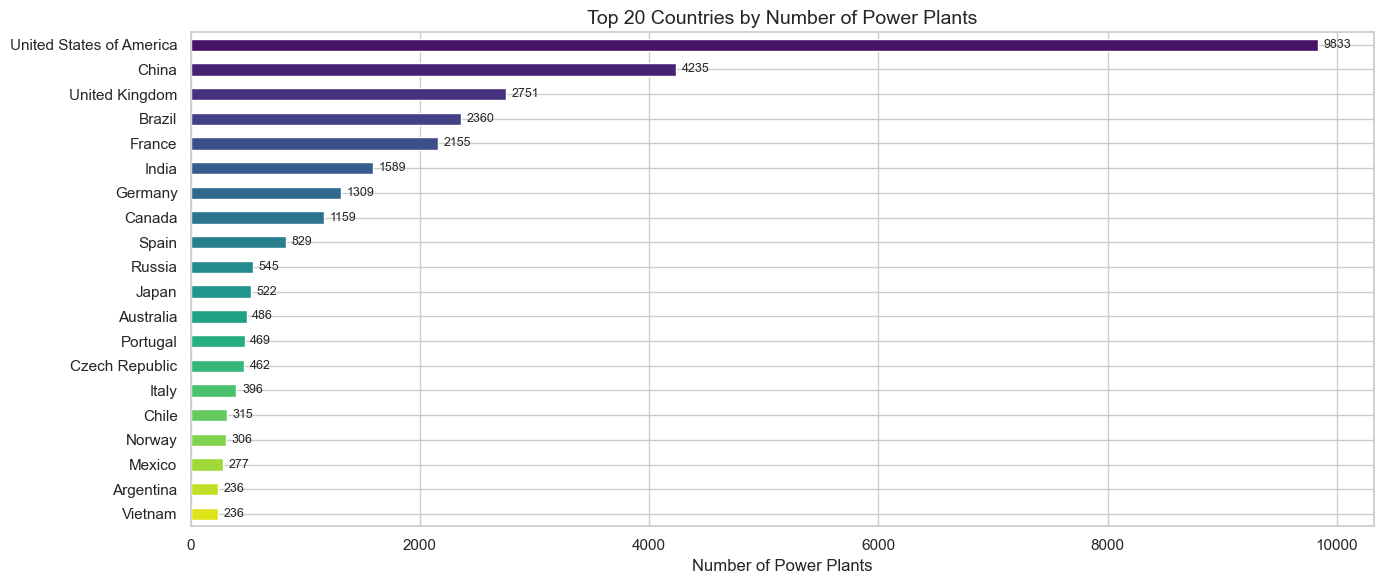

In [7]:
top_countries = df["country_long"].value_counts().head(20)

fig, ax = plt.subplots(figsize=(14, 6))
top_countries.plot(kind="barh", ax=ax, color=sns.color_palette("viridis", 20))
ax.set_xlabel("Number of Power Plants")
ax.set_ylabel("")
ax.set_title("Top 20 Countries by Number of Power Plants")
ax.invert_yaxis()
for i, v in enumerate(top_countries.values):
    ax.text(v + 50, i, str(v), va="center", fontsize=9)
plt.tight_layout()
plt.show()

### 2.3 Distribution by Primary Fuel Type

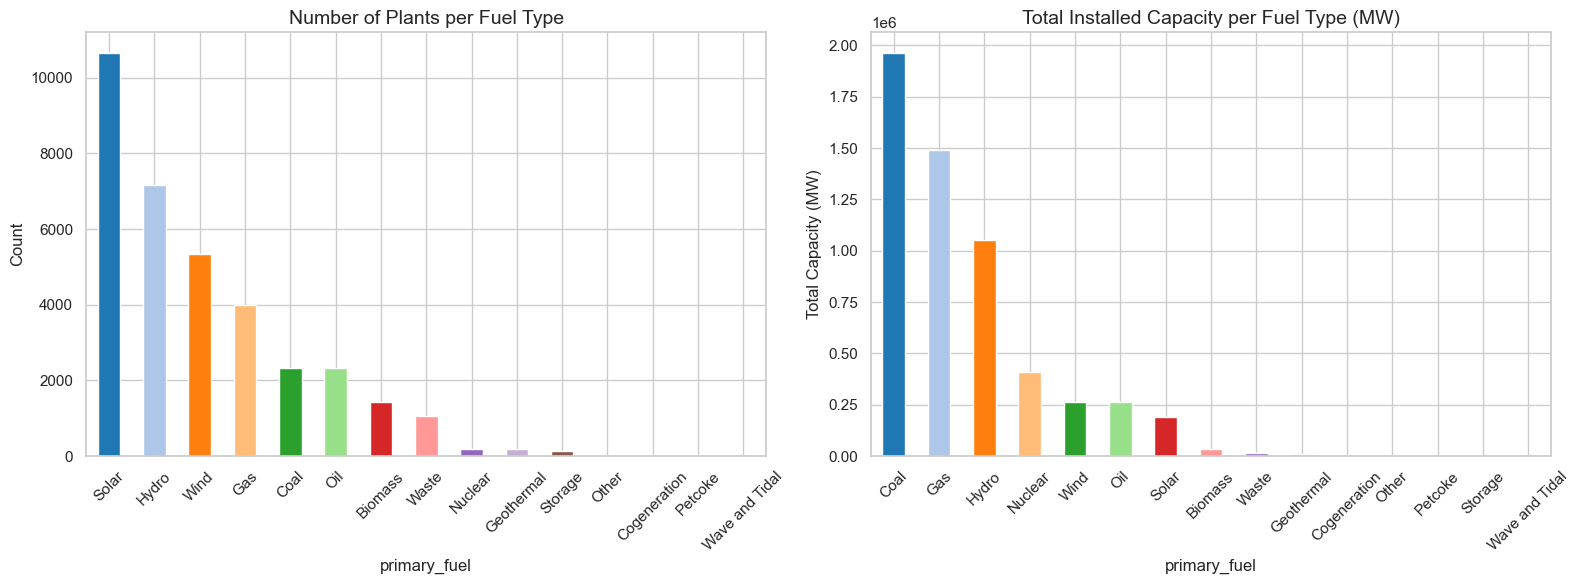

In [8]:
fuel_counts = df["primary_fuel"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# bar plot — count
fuel_counts.plot(kind="bar", ax=axes[0], color=sns.color_palette("tab20", len(fuel_counts)))
axes[0].set_title("Number of Plants per Fuel Type")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

# bar plot — total capacity
fuel_capacity = df.groupby("primary_fuel")["capacity_mw"].sum().sort_values(ascending=False)
fuel_capacity.plot(kind="bar", ax=axes[1], color=sns.color_palette("tab20", len(fuel_capacity)))
axes[1].set_title("Total Installed Capacity per Fuel Type (MW)")
axes[1].set_ylabel("Total Capacity (MW)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### 2.4 Capacity Distribution (Log Scale)

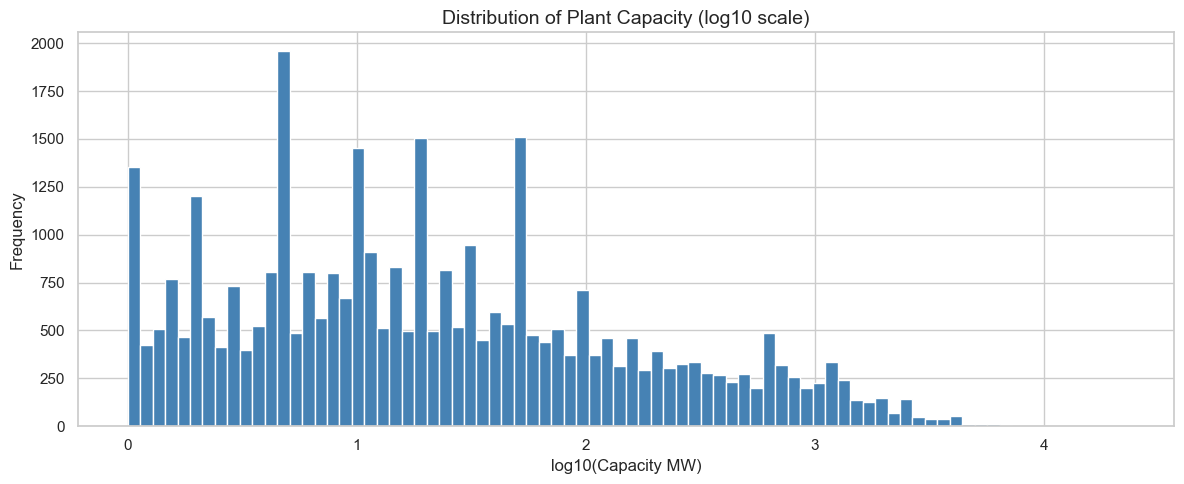

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
df["capacity_mw"].clip(lower=1).apply(np.log10).hist(bins=80, ax=ax, color="steelblue", edgecolor="white")
ax.set_xlabel("log10(Capacity MW)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Plant Capacity (log10 scale)")
plt.tight_layout()
plt.show()

---
## 3. Statistical Analysis of Power Output by Fuel Type

### 3.1 Descriptive Statistics per Fuel Type (NumPy)

In [10]:
#focus on the top fuel types (enough data for meaningful stats)
main_fuels = ["Solar", "Hydro", "Wind", "Gas", "Oil", "Coal", "Nuclear", "Biomass"]
df_main = df[df["primary_fuel"].isin(main_fuels)].copy()

# compute stats using numpy
fuel_stats = {}
for fuel in main_fuels:
    cap = df_main.loc[df_main["primary_fuel"] == fuel, "capacity_mw"].values
    fuel_stats[fuel] = {
        "n": len(cap),
        "mean": np.mean(cap),
        "median": np.median(cap),
        "std": np.std(cap, ddof=1),
        "min": np.min(cap),
        "max": np.max(cap),
        "q25": np.percentile(cap, 25),
        "q75": np.percentile(cap, 75),
    }

fuel_stats_df = pd.DataFrame(fuel_stats).T.round(2)
fuel_stats_df = fuel_stats_df.sort_values("mean", ascending=False)
print(fuel_stats_df.to_string())

               n     mean   median      std   min      max      q25      q75
Nuclear    195.0  2091.86  1888.00  1303.51  20.0   8212.0  1146.65  2668.35
Coal      2330.0   843.58   600.00   888.19   1.2   7000.0   200.00  1200.00
Gas       3998.0   373.45   147.50   560.93   1.0   8865.0    28.42   532.07
Hydro     7156.0   147.17    20.00   549.81   1.0  22500.0     5.40    93.60
Oil       2320.0   112.88     9.00   392.01   1.0   6794.0     2.50    48.00
Wind      5344.0    49.22    27.00   106.14   1.0   6000.0    10.00    49.00
Biomass   1430.0    23.97     9.45    39.46   1.0    528.0     2.90    27.88
Solar    10665.0    17.66     5.80    41.94   1.0   1021.0     2.60    18.00


### 3.2 Hypothesis Testing — Kruskal-Wallis Test

Since the capacity distributions are heavily right-skewed (non-normal), a parametric ANOVA is not the best choice.  
We use the **Kruskal-Wallis H-test** (non-parametric) to test whether median capacity differs significantly between fuel types, followed by **pairwise Mann-Whitney U tests** for the top pairs.

$H_0$: The distributions of capacity across all fuel types are identical.  
$H_1$: At least one fuel type has a significantly different capacity distribution.

In [11]:
#Kruskal-Wallis test
groups = [df_main.loc[df_main["primary_fuel"] == f, "capacity_mw"].values for f in main_fuels]
h_stat, p_val = stats.kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {h_stat:.2f}")
print(f"p-value: {p_val:.2e}")
print(f"\nConclusion: {'Reject H0 — significant differences exist' if p_val < 0.05 else 'Fail to reject H0'}")

Kruskal-Wallis H-statistic: 10770.79
p-value: 0.00e+00

Conclusion: Reject H0 — significant differences exist


In [12]:
#pairwise Mann-Whitney U tests between a few interesting pairs
pairs = [("Nuclear", "Coal"), ("Solar", "Wind"), ("Gas", "Oil"), ("Nuclear", "Solar")]

print("Pairwise Mann-Whitney U tests (alpha = 0.05):")
print("-" * 65)
for f1, f2 in pairs:
    g1 = df_main.loc[df_main["primary_fuel"] == f1, "capacity_mw"].values
    g2 = df_main.loc[df_main["primary_fuel"] == f2, "capacity_mw"].values
    u_stat, p = stats.mannwhitneyu(g1, g2, alternative="two-sided")
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    print(f"  {f1:>10} vs {f2:<10}  U = {u_stat:>12.0f}  p = {p:.2e}  {sig}")

Pairwise Mann-Whitney U tests (alpha = 0.05):
-----------------------------------------------------------------
     Nuclear vs Coal        U =       372938  p = 2.97e-50  ***
       Solar vs Wind        U =     14451929  p = 0.00e+00  ***
         Gas vs Oil         U =      7226322  p = 2.57e-300  ***
     Nuclear vs Solar       U =      2075654  p = 3.63e-126  ***


### 3.3 Box Plots of Capacity by Fuel Type

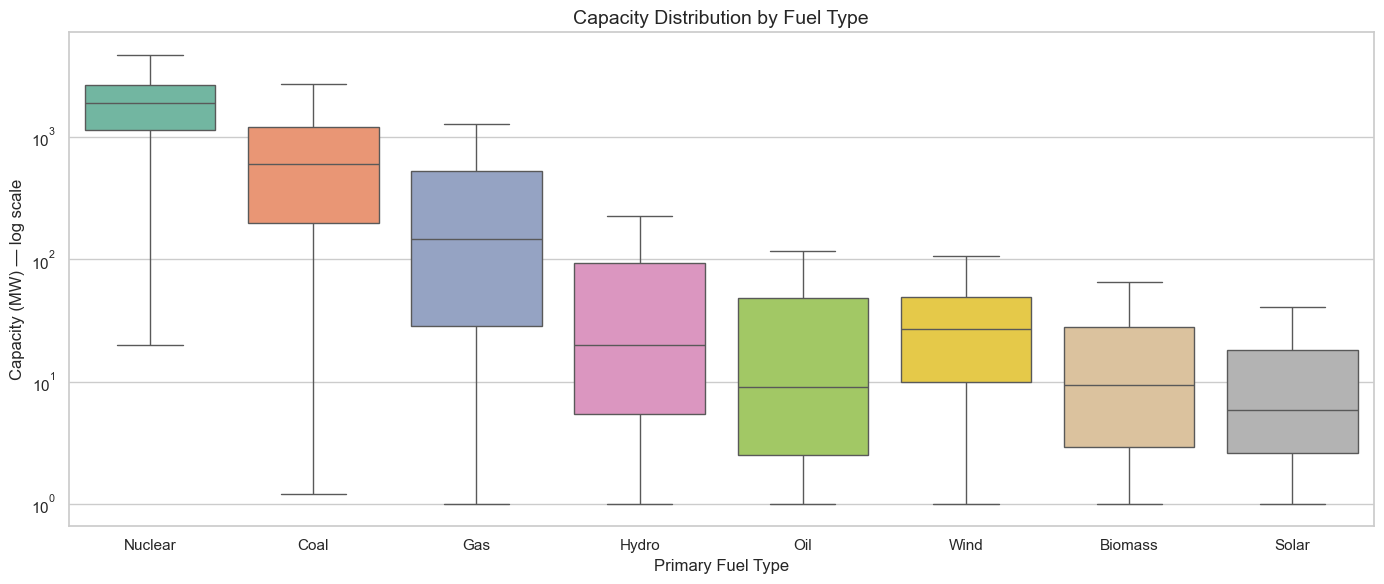

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))
order = fuel_stats_df.index.tolist()
sns.boxplot(data=df_main, x="primary_fuel", y="capacity_mw", order=order, ax=ax,
            showfliers=False, palette="Set2")
ax.set_yscale("log")
ax.set_ylabel("Capacity (MW) — log scale")
ax.set_xlabel("Primary Fuel Type")
ax.set_title("Capacity Distribution by Fuel Type")
plt.tight_layout()
plt.show()

---
## 4. Time Series Analysis

### 4.1 Number of Plants Commissioned Over Time

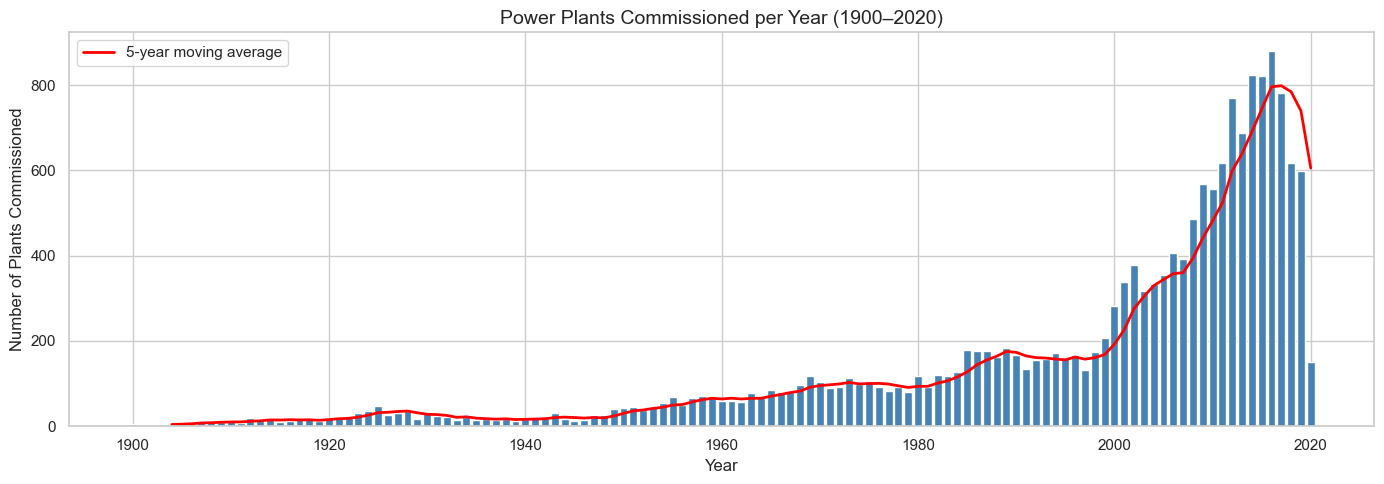

In [14]:
df_time = df.dropna(subset=["commissioning_year"]).copy()
df_time["commissioning_year"] = df_time["commissioning_year"].astype(int)

# filter reasonable range
df_time = df_time[(df_time["commissioning_year"] >= 1900) & (df_time["commissioning_year"] <= 2020)]

yearly_count = df_time.groupby("commissioning_year").size()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(yearly_count.index, yearly_count.values, color="steelblue", width=0.8)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Plants Commissioned")
ax.set_title("Power Plants Commissioned per Year (1900–2020)")

# add a 5-year moving average with numpy
years = yearly_count.index.values.astype(float)
counts = yearly_count.values.astype(float)
window = 5
ma = np.convolve(counts, np.ones(window)/window, mode="valid")
ax.plot(years[window-1:], ma, color="red", linewidth=2, label=f"{window}-year moving average")
ax.legend()
plt.tight_layout()
plt.show()

### 4.2 Evolution of Fuel Mix Over Decades

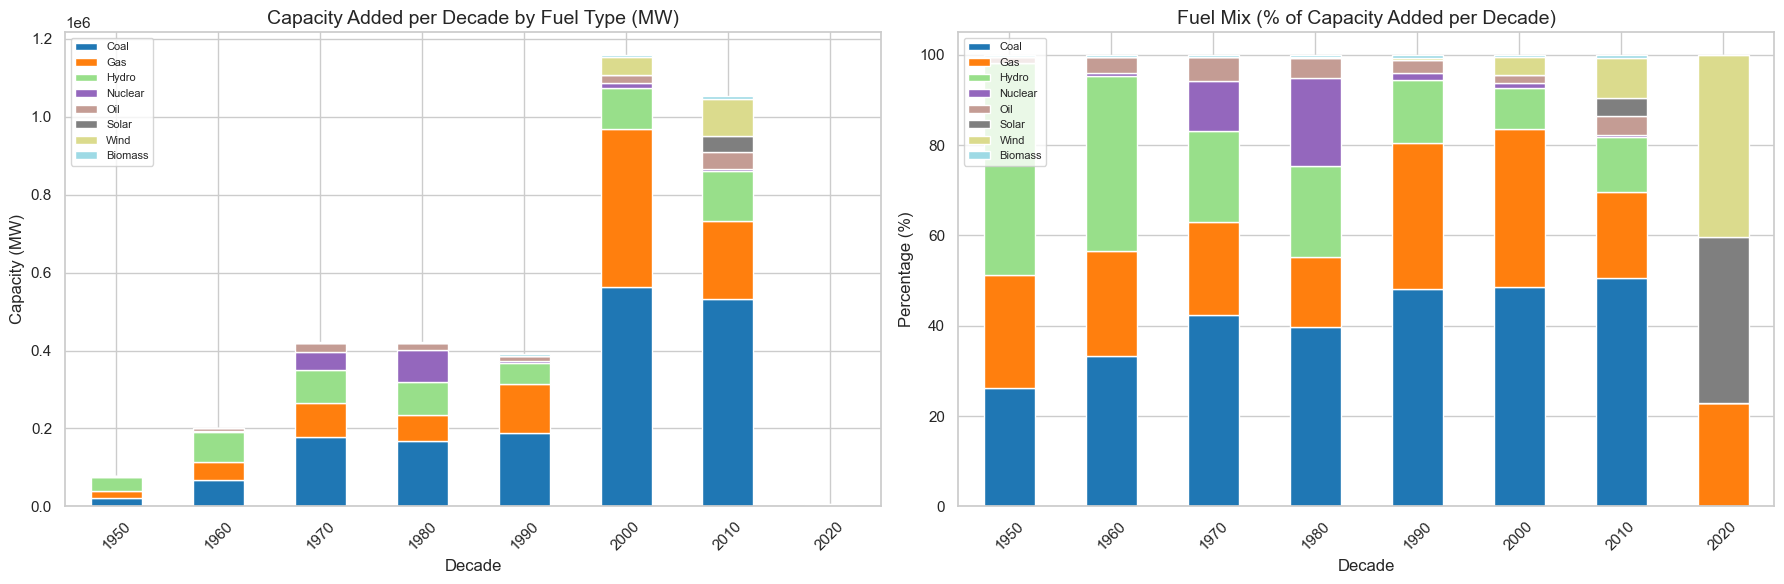

In [15]:
df_time["decade"] = (df_time["commissioning_year"] // 10) * 10
df_time_recent = df_time[df_time["decade"] >= 1950]

# group and count capacity added per decade per fuel
fuel_decade = df_time_recent.groupby(["decade", "primary_fuel"])["capacity_mw"].sum().reset_index()
fuel_decade_pivot = fuel_decade.pivot_table(index="decade", columns="primary_fuel",
                                             values="capacity_mw", aggfunc="sum", fill_value=0)

# keep main fuels only for readability
keep_fuels = ["Coal", "Gas", "Hydro", "Nuclear", "Oil", "Solar", "Wind", "Biomass"]
fuel_decade_pivot = fuel_decade_pivot[[f for f in keep_fuels if f in fuel_decade_pivot.columns]]

# normalize to percentages for a stacked area chart
fuel_pct = fuel_decade_pivot.div(fuel_decade_pivot.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# absolute stacked bar
fuel_decade_pivot.plot(kind="bar", stacked=True, ax=axes[0], colormap="tab20")
axes[0].set_title("Capacity Added per Decade by Fuel Type (MW)")
axes[0].set_xlabel("Decade")
axes[0].set_ylabel("Capacity (MW)")
axes[0].legend(loc="upper left", fontsize=8)
axes[0].tick_params(axis="x", rotation=45)

# percentage stacked bar
fuel_pct.plot(kind="bar", stacked=True, ax=axes[1], colormap="tab20")
axes[1].set_title("Fuel Mix (% of Capacity Added per Decade)")
axes[1].set_xlabel("Decade")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend(loc="upper left", fontsize=8)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### 4.3 Trend Analysis with NumPy — Linear Regression on Renewable Capacity

We use NumPy's `polyfit` to fit a linear trend on yearly renewable capacity additions (Solar + Wind).

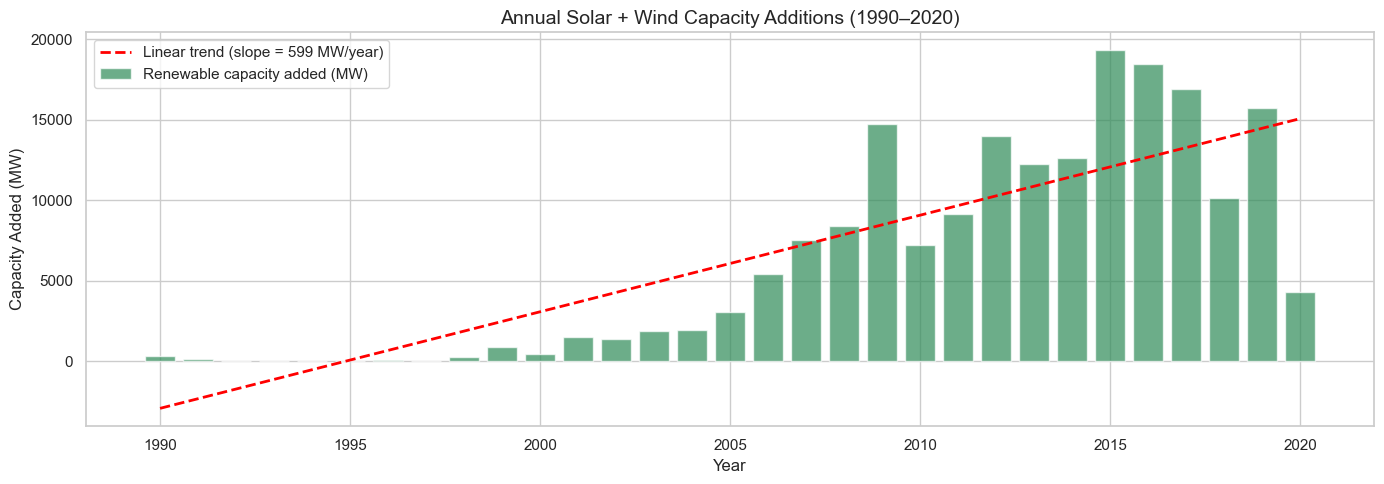

Linear regression coefficients (NumPy polyfit):
  slope  = 599.17 MW/year
  intercept = -1195260.08


In [16]:
renewables = ["Solar", "Wind"]
df_renew = df_time[df_time["primary_fuel"].isin(renewables)]
renew_yearly = df_renew.groupby("commissioning_year")["capacity_mw"].sum()

# filter to years with meaningful data
renew_yearly = renew_yearly[renew_yearly.index >= 1990]

x = renew_yearly.index.values.astype(float)
y = renew_yearly.values.astype(float)

# numpy polyfit — linear
coeffs = np.polyfit(x, y, deg=1)
trend_line = np.polyval(coeffs, x)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x, y, color="seagreen", alpha=0.7, label="Renewable capacity added (MW)")
ax.plot(x, trend_line, color="red", linewidth=2, linestyle="--",
        label=f"Linear trend (slope = {coeffs[0]:.0f} MW/year)")
ax.set_xlabel("Year")
ax.set_ylabel("Capacity Added (MW)")
ax.set_title("Annual Solar + Wind Capacity Additions (1990–2020)")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Linear regression coefficients (NumPy polyfit):")
print(f"  slope  = {coeffs[0]:.2f} MW/year")
print(f"  intercept = {coeffs[1]:.2f}")

---
## 5. Advanced Visualization

### 5.1 Geographical Distribution of Power Plants

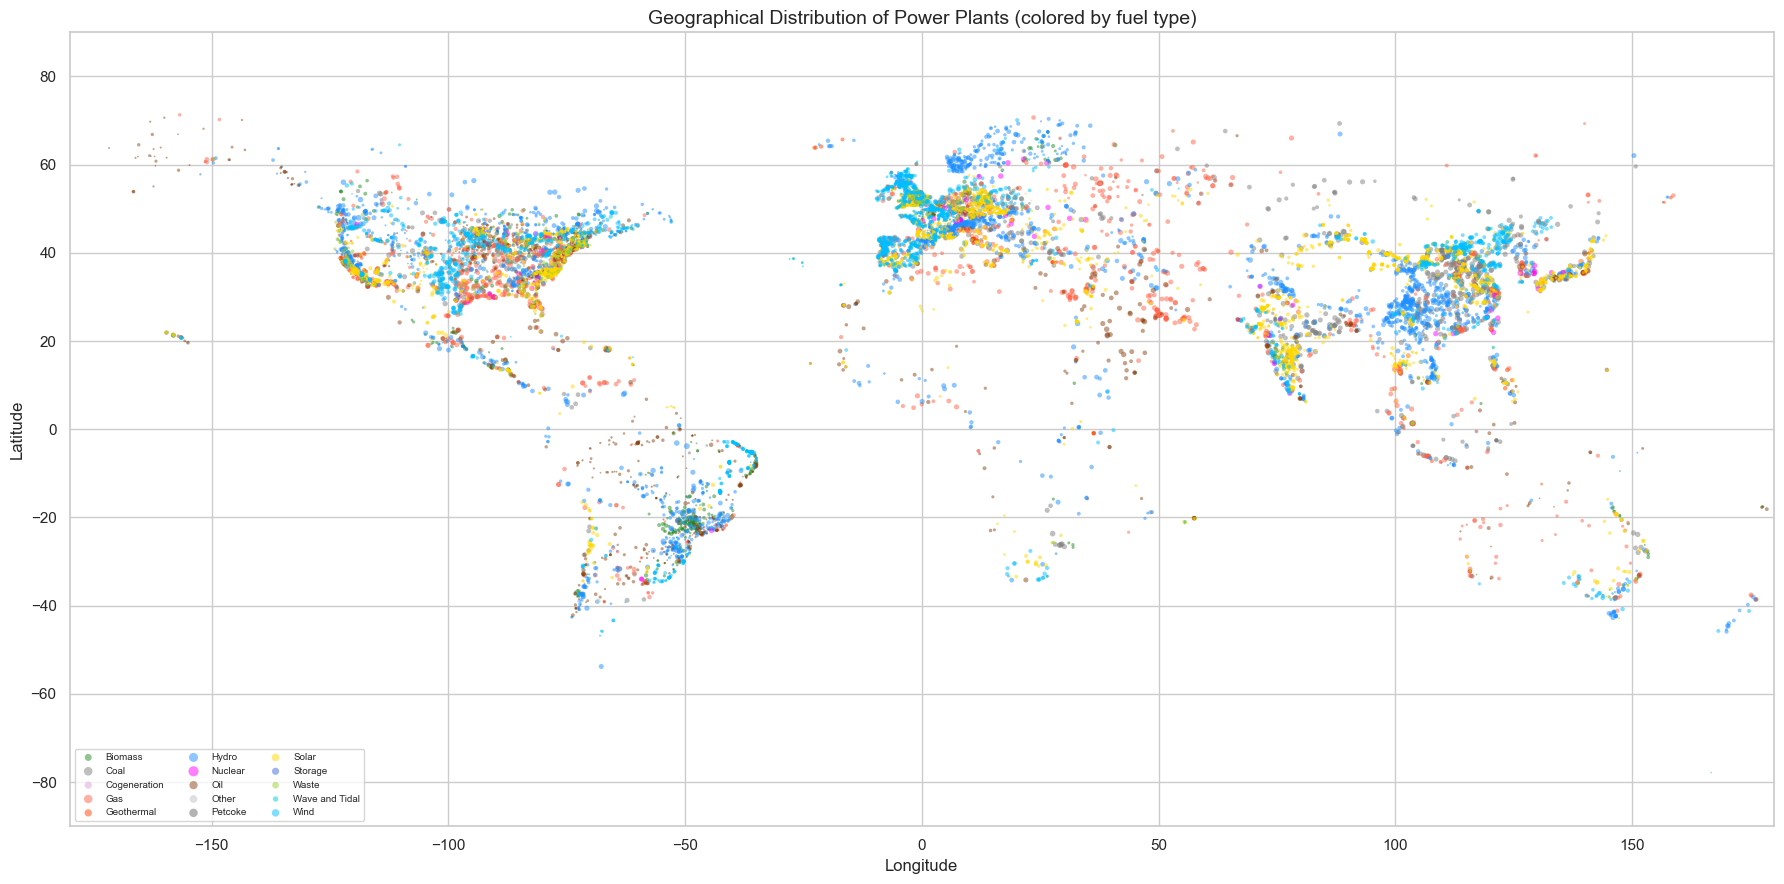

In [17]:
fig, ax = plt.subplots(figsize=(18, 9))

# sample for readability (plotting 35k points gets messy)
df_plot = df.sample(n=min(15000, len(df)), random_state=42)

# color by fuel type
fuel_colors = {
    "Solar": "#FFD700", "Wind": "#00BFFF", "Hydro": "#1E90FF",
    "Gas": "#FF6347", "Coal": "#808080", "Oil": "#8B4513",
    "Nuclear": "#FF00FF", "Biomass": "#228B22", "Other": "#C0C0C0",
    "Geothermal": "#FF4500", "Waste": "#9ACD32", "Storage": "#4169E1",
    "Petcoke": "#696969", "Wave and Tidal": "#00CED1", "Cogeneration": "#DDA0DD"
}

for fuel, group in df_plot.groupby("primary_fuel"):
    color = fuel_colors.get(fuel, "#999999")
    ax.scatter(group["longitude"], group["latitude"], s=np.log1p(group["capacity_mw"]) * 2,
               alpha=0.5, label=fuel, color=color, edgecolors="none")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Geographical Distribution of Power Plants (colored by fuel type)")
ax.legend(loc="lower left", fontsize=7, ncol=3, markerscale=2)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
plt.tight_layout()
plt.show()

### 5.2 Heatmap — Average Capacity by Fuel Type and Top Countries

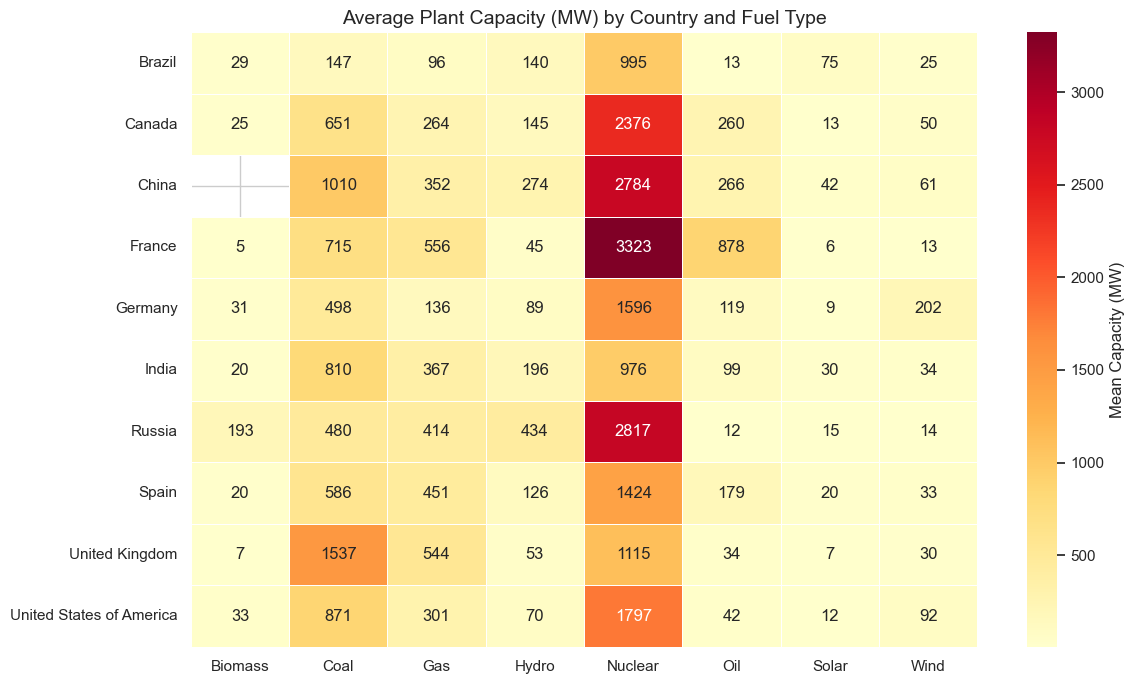

In [18]:
top10_countries = df["country_long"].value_counts().head(10).index.tolist()
df_heat = df[df["country_long"].isin(top10_countries) & df["primary_fuel"].isin(main_fuels)]

heatmap_data = df_heat.pivot_table(index="country_long", columns="primary_fuel",
                                    values="capacity_mw", aggfunc="mean")

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrRd", ax=ax,
            linewidths=0.5, cbar_kws={"label": "Mean Capacity (MW)"})
ax.set_title("Average Plant Capacity (MW) by Country and Fuel Type")
ax.set_ylabel("")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

### 5.3 Violin Plot — Capacity Distribution by Fuel

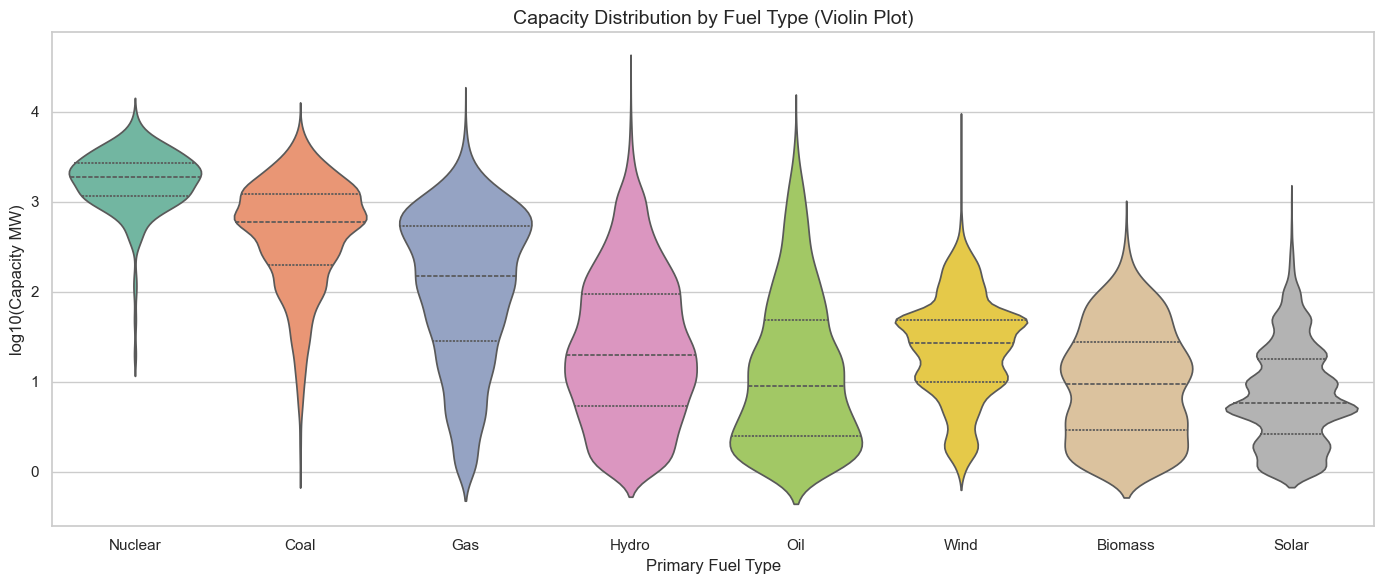

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
df_violin = df_main.copy()
df_violin["log_capacity"] = np.log10(df_violin["capacity_mw"].clip(lower=1))

sns.violinplot(data=df_violin, x="primary_fuel", y="log_capacity",
               order=order, palette="Set2", ax=ax, inner="quartile")
ax.set_ylabel("log10(Capacity MW)")
ax.set_xlabel("Primary Fuel Type")
ax.set_title("Capacity Distribution by Fuel Type (Violin Plot)")
plt.tight_layout()
plt.show()

---
## 6. Matrix Operations in Real-World Context

### 6.1 Correlation Matrix & Eigenvalue Decomposition

We build a correlation matrix between numerical features and decompose it using eigenvalues/eigenvectors.  
This is essentially what PCA does under the hood — the eigenvectors point in the directions of maximum variance in the data, and the eigenvalues tell us how much variance each direction captures.

In [20]:
#select numerical features for correlation analysis
features = ["capacity_mw", "latitude", "longitude", "commissioning_year", "generation_gwh"]
df_matrix = df[features].dropna()

# standardize using numpy
X = df_matrix.values
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0, ddof=1)
X_standardized = (X - X_mean) / X_std

# correlation matrix via numpy (equivalent to pearson r on standardized data)
corr_matrix = np.corrcoef(X_standardized, rowvar=False)

print("Correlation Matrix (NumPy):")
corr_df = pd.DataFrame(corr_matrix, index=features, columns=features).round(3)
print(corr_df.to_string())

Correlation Matrix (NumPy):
                    capacity_mw  latitude  longitude  commissioning_year  generation_gwh
capacity_mw               1.000    -0.005      0.342              -0.012           0.933
latitude                 -0.005     1.000     -0.113              -0.151          -0.013
longitude                 0.342    -0.113      1.000              -0.024           0.345
commissioning_year       -0.012    -0.151     -0.024               1.000           0.003
generation_gwh            0.933    -0.013      0.345               0.003           1.000


In [21]:
# eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)

# sort by descending eigenvalue
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# variance explained
var_explained = eigenvalues / np.sum(eigenvalues) * 100
cum_var = np.cumsum(var_explained)

print("Eigenvalue Decomposition of the Correlation Matrix:")
print("-" * 55)
for i, (ev, ve, cv) in enumerate(zip(eigenvalues, var_explained, cum_var)):
    print(f"  PC{i+1}: eigenvalue = {ev:.4f}  |  variance = {ve:.1f}%  |  cumulative = {cv:.1f}%")

Eigenvalue Decomposition of the Correlation Matrix:
-------------------------------------------------------
  PC1: eigenvalue = 2.1429  |  variance = 42.9%  |  cumulative = 42.9%
  PC2: eigenvalue = 1.1594  |  variance = 23.2%  |  cumulative = 66.0%
  PC3: eigenvalue = 0.9038  |  variance = 18.1%  |  cumulative = 84.1%
  PC4: eigenvalue = 0.7266  |  variance = 14.5%  |  cumulative = 98.7%
  PC5: eigenvalue = 0.0672  |  variance = 1.3%  |  cumulative = 100.0%


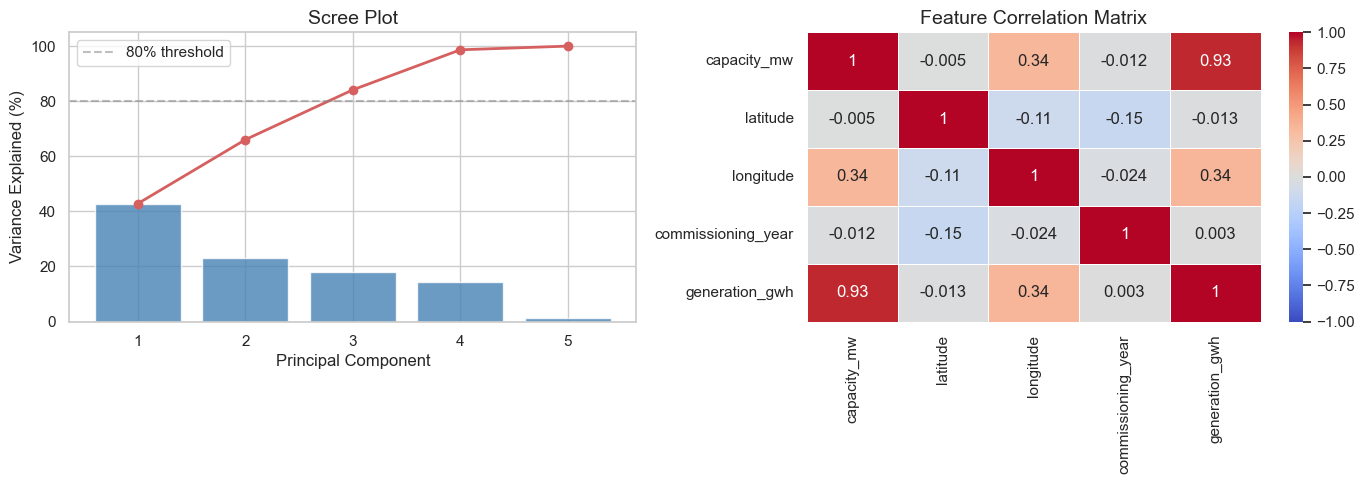

In [22]:
# visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scree plot
axes[0].bar(range(1, len(eigenvalues)+1), var_explained, color="steelblue", alpha=0.8)
axes[0].plot(range(1, len(eigenvalues)+1), cum_var, "ro-", linewidth=2)
axes[0].axhline(y=80, color="gray", linestyle="--", alpha=0.5, label="80% threshold")
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Variance Explained (%)")
axes[0].set_title("Scree Plot")
axes[0].legend()

# heatmap of correlation matrix
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, ax=axes[1],
            vmin=-1, vmax=1, linewidths=0.5)
axes[1].set_title("Feature Correlation Matrix")

plt.tight_layout()
plt.show()

### 6.2 Interpretation of Eigenvectors and Eigenvalues

In this context:

- **Eigenvalues** represent the amount of variance captured by each principal component. A large eigenvalue means that component explains a lot of the spread in the data.
- **Eigenvectors** define the direction (i.e., which combination of original features) each component corresponds to.

This is relevant because it tells us, for instance, whether capacity and generation are essentially capturing the same underlying dimension (they should be strongly correlated), or whether geographic location (lat/lon) adds independent information. In engineering terms, it's a dimensionality reduction — we can describe the dataset with fewer variables without losing much information, which is useful for modeling or visualization.

In [23]:
# display eigenvectors (loadings) for interpretation
loadings = pd.DataFrame(eigenvectors, index=features,
                         columns=[f"PC{i+1}" for i in range(len(features))])
print("Eigenvector Loadings (first 3 PCs):")
print(loadings.iloc[:, :3].round(3).to_string())

Eigenvector Loadings (first 3 PCs):
                      PC1    PC2    PC3
capacity_mw         0.648 -0.071  0.172
latitude           -0.049 -0.724  0.494
longitude           0.395  0.133 -0.501
commissioning_year -0.007  0.671  0.666
generation_gwh      0.649 -0.057  0.178


---
## 7. Integrating NumPy with Pandas and Matplotlib

### 7.1 Complex Filtering with NumPy Masks in Pandas

Example: find all plants that are above the 95th percentile in capacity AND were commissioned after 2000 AND are renewable.

In [24]:
# compute threshold with numpy
cap_95 = np.percentile(df["capacity_mw"].values, 95)
print(f"95th percentile capacity: {cap_95:.1f} MW")

# numpy boolean mask
mask = (
    (df["capacity_mw"].values > cap_95) &
    (df["commissioning_year"].values > 2000) &
    np.isin(df["primary_fuel"].values, ["Solar", "Wind", "Hydro", "Geothermal", "Biomass"])
)

df_filtered = df.loc[mask, ["name", "country_long", "primary_fuel", "capacity_mw", "commissioning_year"]]
df_filtered = df_filtered.sort_values("capacity_mw", ascending=False)
print(f"\nFound {len(df_filtered)} large renewable plants commissioned after 2000:")
df_filtered.head(15)

95th percentile capacity: 903.9 MW

Found 65 large renewable plants commissioned after 2000:


,name,country_long,primary_fuel,capacity_mw,commissioning_year
8453,Three Gorges Dam,China,Hydro,22500.00000,2003.0
8755,Xiluodu,China,Hydro,12600.00000,2013.0
8707,Xiangjiaba,China,Hydro,6448.00000,2014.0
7447,Longtan,China,Hydro,6300.00000,2009.0
7152,Jinping II,China,Hydro,4400.00000,2016.0
7278,Laxiwa,China,Hydro,4200.00000,2010.0
2257,Jirau,Brazil,Hydro,3750.00000,2013.0
7151,Jinping I,China,Hydro,3600.00000,2014.0
3024,Santo Antônio,Brazil,Hydro,3568.00000,2012.0
1385,Belo Monte,Brazil,Hydro,3327.45544,2016.0


### 7.2 NumPy-Enhanced Visualization — Custom Histogram with Fitted Distribution

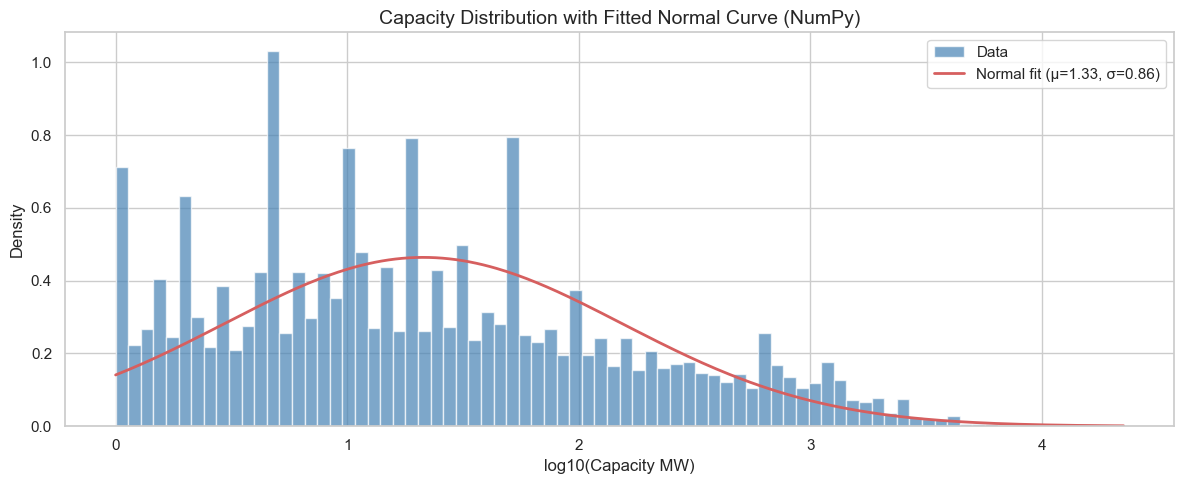

In [25]:
# take log-capacity and fit a normal distribution using numpy
log_cap = np.log10(df["capacity_mw"].values.clip(min=1))

mu = np.mean(log_cap)
sigma = np.std(log_cap, ddof=1)

fig, ax = plt.subplots(figsize=(12, 5))

# histogram
counts, bins, patches = ax.hist(log_cap, bins=80, density=True, color="steelblue",
                                 alpha=0.7, edgecolor="white", label="Data")

# fitted normal curve using numpy
x_fit = np.linspace(bins[0], bins[-1], 300)
y_fit = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_fit - mu) / sigma)**2)
ax.plot(x_fit, y_fit, "r-", linewidth=2, label=f"Normal fit (μ={mu:.2f}, σ={sigma:.2f})")

ax.set_xlabel("log10(Capacity MW)")
ax.set_ylabel("Density")
ax.set_title("Capacity Distribution with Fitted Normal Curve (NumPy)")
ax.legend()
plt.tight_layout()
plt.show()

### 7.3 Using NumPy for Rolling Statistics in Pandas

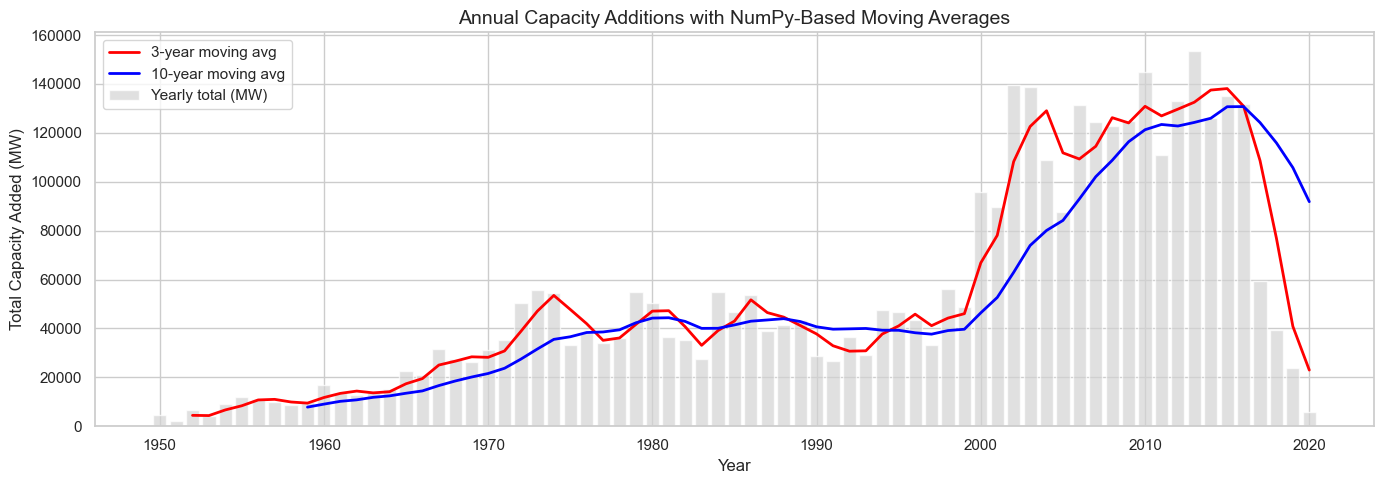

In [26]:
# rolling mean of yearly capacity additions using numpy convolution
yearly_cap = df_time.groupby("commissioning_year")["capacity_mw"].sum()
yearly_cap = yearly_cap[yearly_cap.index >= 1950]

window_sizes = [3, 10]
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(yearly_cap.index, yearly_cap.values, color="lightgray", alpha=0.7, label="Yearly total (MW)")

colors = ["red", "blue"]
for w, c in zip(window_sizes, colors):
    kernel = np.ones(w) / w
    smoothed = np.convolve(yearly_cap.values, kernel, mode="valid")
    x_smooth = yearly_cap.index.values[w-1:]
    ax.plot(x_smooth, smoothed, color=c, linewidth=2, label=f"{w}-year moving avg")

ax.set_xlabel("Year")
ax.set_ylabel("Total Capacity Added (MW)")
ax.set_title("Annual Capacity Additions with NumPy-Based Moving Averages")
ax.legend()
plt.tight_layout()
plt.show()

### 7.4 Matrix Multiplication — Weighted Fuel Score per Country

As a practical example of matrix operations, we compute a "diversity-weighted capacity score" per country.  
We define a weight vector (e.g., favoring renewables) and multiply it by the fuel-capacity matrix.

In [27]:
# build a country x fuel capacity matrix
top15 = df["country_long"].value_counts().head(15).index.tolist()
df_top = df[df["country_long"].isin(top15) & df["primary_fuel"].isin(main_fuels)]
pivot = df_top.pivot_table(index="country_long", columns="primary_fuel",
                            values="capacity_mw", aggfunc="sum", fill_value=0)

# define a weight vector: higher weights for clean energy
weights = {
    "Solar": 1.0, "Wind": 1.0, "Hydro": 0.8, "Nuclear": 0.7,
    "Biomass": 0.5, "Gas": 0.3, "Oil": 0.1, "Coal": 0.1
}
w = np.array([weights.get(f, 0) for f in pivot.columns])

# matrix-vector multiplication: country scores
A = pivot.values  # shape (15, n_fuels)
scores = A @ w    # numpy matrix multiplication

result = pd.DataFrame({
    "country": pivot.index,
    "weighted_clean_score": scores,
    "total_capacity_mw": A.sum(axis=1)
}).sort_values("weighted_clean_score", ascending=False)

print("Country 'Clean Energy Score' (matrix multiplication A @ w):")
print(result.to_string(index=False))

Country 'Clean Energy Score' (matrix multiplication A @ w):
                 country  weighted_clean_score  total_capacity_mw
United States of America         491857.530000       1.186189e+06
                   China         450031.110000       1.415041e+06
                  Brazil         102841.973562       1.473359e+05
                   India         100437.313800       3.160885e+05
                  Canada          97003.070000       1.435417e+05
                  Russia          93997.667000       2.281164e+05
                   Japan          82135.845000       2.148085e+05
                  France          76463.372920       1.103714e+05
          United Kingdom          54245.583480       9.132878e+04
                   Spain          42952.785100       7.864701e+04
                 Germany          40856.039880       1.096947e+05
                   Italy          26120.539000       7.185346e+04
               Australia          25677.863000       6.566339e+04
                

---
## 8. Key Insights & Conclusions

1. **Dominant fuel types:** Solar and Hydro lead in plant count, but Coal, Gas, and Nuclear dominate in total installed capacity — a few large plants carry most of the generation weight.

2. **Statistical differences:** The Kruskal-Wallis test confirms statistically significant differences in plant capacity across fuel types. Nuclear plants are by far the largest on average, while Solar and Wind tend to be smaller individual installations.

3. **Time trends:** There is a clear acceleration in renewable (Solar + Wind) capacity additions since ~2005. The linear trend from NumPy polyfit shows an exponential-like growth pattern when viewed year by year.

4. **Fuel mix evolution:** The 2010s marked a turning point — Solar and Wind went from marginal to major contributors in new capacity additions. Coal has been declining since the 2000s in new builds.

5. **PCA / Eigenvalue analysis:** Capacity and generation are strongly correlated (as expected — larger plants generate more). Geographic coordinates contribute independent variance, meaning location information adds value beyond capacity data alone.

6. **Matrix operations:** The weighted clean-energy score demonstrates how matrix multiplication can be used to aggregate multidimensional data into a single meaningful metric — a practical application of linear algebra in energy policy analysis.

---
